In [34]:
# Load modules for data manipulation
from dotenv import load_dotenv
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import call
import pandas as pd
import numpy as np
import os
import time

In [2]:
# Load modules for machine learning
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split

# Import the model we are using
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

# Calculate the accurancy of the model
from sklearn.metrics import accuracy_score, classification_report

# For drawing the graph
from sklearn.tree import export_graphviz

In [3]:
load_dotenv()

True

In [4]:
# clt = pd.read_csv(os.getenv('CLEANED_DATA_PATH') + '/' + 'TJ38.csv', encoding='ISO-8859-1', sep='\t')
clt = pd.read_csv(os.getenv('CLEANED_DATA_PATH') + '/' + 'TR35.csv', encoding='ISO-8859-1', sep='\t', low_memory=False)
ctr = pd.read_csv(os.getenv('CLEANED_DATA_PATH') + '/' + 'TJ7S.csv', encoding='ISO-8859-1', sep='\t', usecols=['COCO', 'COMAX', 'COPRO'], low_memory=False)

eco = pd.read_csv(os.getenv('CLEANED_DATA_PATH') + '/' + 'eco-products.csv', encoding='ISO-8859-1', sep='\t')

## Get the best ecological product

In [81]:
# Get the list of all the eco products code
eco = [str(i).zfill(5) for i in eco['COPRO']]

# Declare the list of products for each family
# Les familles sont: CREDITS, DEPOTS MONETAIRES, PRODUITS EXTERNES COMMERCIALISES
credit = ['568', '943', '942', '546', '547', '3992', '940', '941', '548', '6458', '509', '565']
depot = ['7648', '7649', '7606', '3']
comm = ['5808', '5807']

# ECO: 00003 | 242568 - LIVRET DEVELOPPEMENT DURABLE ET SOLIDAIRE
# DEPOTS MONETAIRES - EPARGNE MONETAIRE LIQUIDE - LIVRETS REGLEMENTES
# ctr[ctr['COPRO'].isin(eco)]['COPRO'].value_counts()

## Concatinate with other tables TJ39 - TJDR - TJER

In [6]:
tj39 = pd.read_csv(os.getenv('DATA_PATH') + '/' + 'tj39.csv', encoding='ISO-8859-1', sep=';', usecols=['COMAX', 'MSMENC', 'MTPATR', 'MTVAOP'])
tjdr = pd.read_csv(os.getenv('DATA_PATH') + '/' + 'tjdr.csv', encoding='ISO-8859-1', sep=';', usecols=['COMAX', 'MTRVIM', 'MTRVFR', 'QTPAFI', 'COHAVI'])
tjer = pd.read_csv(os.getenv('DATA_PATH') + '/' + 'tjer.csv', encoding='ISO-8859-1', sep=';', usecols=['COMAX', 'MTAPJE', 'MTPJE'])

In [7]:
# pour le cas de la table tj39, la variable COMAX elle est de 13 caracteres
# or celle des autres tables sont de 10, donc il fallait convertir de 13 a 10
# on prend les 10 premiers caractères du COMAX de tj39, d'apres le data engineer
# de la PBS.
tj39['COMAX'] = [val[:10] for val in tj39['COMAX'].values]

In [8]:
# This table is only good fot the moral clients only
data = pd.merge(clt,tj39,on='COMAX',how='left')
data = pd.merge(data,tjer,on='COMAX',how='left')
data = pd.merge(data,tjdr,on='COMAX',how='left')

In [9]:
data.shape

(1689052, 120)

In [10]:
data = data.drop_duplicates(subset="COMAX")

In [11]:
data['CTSCPI'] = data['CTSCPI'].astype(str)
data['COPOST'] = data['COPOST'].astype(str)

data['COPOST'].replace('nan', np.nan, inplace=True)
data['CTSCPI'].replace('nan', np.nan, inplace=True)

data.dropna(subset=['COPOST'], inplace=True)
data.dropna(subset=['CTSCPI'], inplace=True)

In [12]:
# replace Male with 0, et F avec 1
data['COSEXE'].replace('M', 0, inplace=True)
data['COSEXE'].replace('F', 1, inplace=True)

In [13]:
# get the ids of the products
ids = ctr[ctr['COPRO'].isin(eco)]['COMAX'].values
data['ECO'] = data['COMAX'].isin(ids)

In [14]:
# these values are based int but detected as object
why = ['CTCOPO', 'CTMENB', 'CTSIFA', 'COPOAG', 'CTSC90', 'CTSC91', 'CTSC92', 'CTFORT','PSGPAR',
'CEBPF1', 'CEBPF2', 'CEBPF3', 'CEBPF4', 'CEBPF5', 'CEBPF6', 'CEBPF7', 'CTBP']

for i in why:
    for k in [j for j in data[i].unique() if j.strip() == '']:
         data[i].replace(k, np.nan, inplace=True)

In [71]:
to_del = {'QCBPFA', 'COPOST', 'COGRRB', 'COESPF', 'QCLDD', 'MTELDD', 'COPOAG', 'QCCONT', 'QCLIVR', 'QCLIVJ', 'QCCSL', 'QCLEP', 'MTELDD', 'MTELIJ'}
cols = list(data.columns.values[1:-1])

for i in list(to_del):
    cols.remove(i)

for l in cols:
    try:
        data[l] = data[l].fillna(data[l].median())
    except:
        cols.remove(l)

In [27]:
'''for i in cols:
    print(i, data[i].isna().sum())'''
# data['CTMENB'] = data[''].fillna(data[''].median())

'for i in cols:\n    print(i, data[i].isna().sum())'

In [62]:
len(cols)

104

In [63]:
%store data
%store cols
%store eco

Stored 'data' (DataFrame)
Stored 'cols' (list)
Stored 'eco' (list)


In [83]:
def random_forest(data, ecos, cols):   
    ''' The Model'''
    
    # Labels are the values we want to predict
    labels = np.array(data['ECO'])

    # Remove the labels from the features
    features = np.array(data[cols])

    # Split the data into training and testing sets
    train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.2)

    # Instantiate model with 1000 decision trees
    rf = RandomForestRegressor(n_estimators = 300)

    # Train the model on training data
    rf.fit(train_features, train_labels)

    # Use the forest's predict method on the test data
    predictions = rf.predict(test_features)

    # Classification report
    print(classification_report(test_labels, predictions.round()))    

In [65]:
def knn(data, ecos, cols):
    ''' The Model'''
    
    # Labels are the values we want to predict
    labels = np.array(data['ECO'])

    # Remove the labels from the features
    features = np.array(data[cols])

    # Split the data into training and testing sets, random_state = 42
    train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.2, random_state=42)

    # Instantiate model with 1000 decision trees
    model = KNeighborsClassifier(n_neighbors=3)
    
    # Train the model on training data
    model.fit(train_features, train_labels)
    
    # Use the forest's predict method on the test data
    predictions = model.predict(test_features)

    # Classification report
    print(classification_report(test_labels, predictions.round()))

In [66]:
def log_reg(data, ecos, cols):
    ''' The Model'''
    
    # Labels are the values we want to predict
    labels = np.array(data['ECO'])

    # Remove the labels from the features
    features = np.array(data[cols])

    # Split the data into training and testing sets
    train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.2, random_state=42)

    # Instantiate model with 1000 decision trees
    logisticRegr = LogisticRegression()
    
    # Train the model on training data
    logisticRegr.fit(train_features, train_labels)
    
    # Use the forest's predict method on the test data
    predictions = logisticRegr.predict(test_features)

    # Classification report
    print(classification_report(test_labels, predictions.round()))

In [85]:
''' The Model'''

# Labels are the values we want to predict
labels = np.array(data['ECO'])

# Remove the labels from the features
features = np.array(data[cols])

# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.2)

In [86]:
# Instantiate model with 300 decision trees
rf = RandomForestRegressor(n_estimators = 300)

st = time.time()

# Train the model on training data
rf.fit(train_features, train_labels)

fn = time.time()
print(fn - st)

# Use the forest's predict method on the test data
predictions = rf.predict(test_features)

print(time.time() - fn)

# Classification report
print(classification_report(test_labels, predictions.round()))

2347.960119009018
11.459137678146362
              precision    recall  f1-score   support

       False       0.88      0.91      0.90     69134
        True       0.79      0.74      0.76     32145

    accuracy                           0.86    101279
   macro avg       0.84      0.82      0.83    101279
weighted avg       0.85      0.86      0.85    101279



In [88]:
# CREDITS
print('CREDITS')
random_forest(data, credit, cols)

# DEPOTS MONETAIRES
print('DEPOTS MONETAIRES')
random_forest(data, depot, cols)

# PRODUITS EXTERNES COMMERCIALISES
print('PRODUITS EXTERNES COMMERCIALISES')
random_forest(data, comm, cols)

CREDITS
              precision    recall  f1-score   support

       False       0.88      0.91      0.90     69279
        True       0.79      0.74      0.77     32000

    accuracy                           0.86    101279
   macro avg       0.84      0.83      0.83    101279
weighted avg       0.85      0.86      0.86    101279

DEPOTS MONETAIRES
              precision    recall  f1-score   support

       False       0.88      0.91      0.90     69200
        True       0.79      0.74      0.77     32079

    accuracy                           0.86    101279
   macro avg       0.84      0.83      0.83    101279
weighted avg       0.85      0.86      0.86    101279

PRODUITS EXTERNES COMMERCIALISES
              precision    recall  f1-score   support

       False       0.88      0.91      0.90     69007
        True       0.79      0.74      0.77     32272

    accuracy                           0.86    101279
   macro avg       0.84      0.82      0.83    101279
weighted avg   

# - - - - - - - -- - - - - - - - - - - - - - - - -- - - - - - 

In [77]:
def plot_feature_importance(importance,names,model_type):
    #Create arrays from feature importance and feature name logistic regressions
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + '-FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')
    
    plt.savefig('{}.svg'.format(model_type))

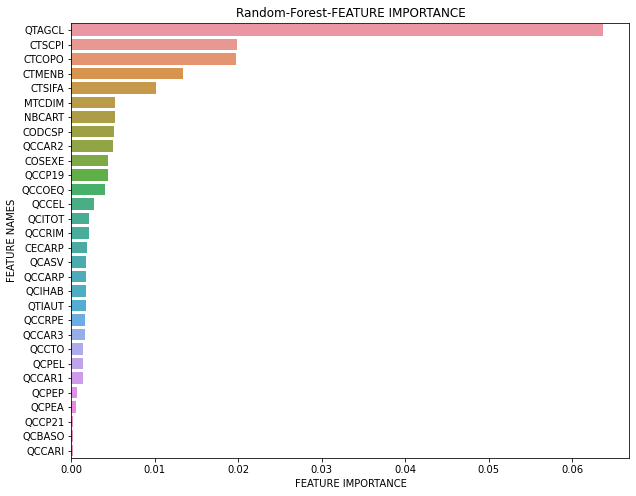

In [80]:
plot_feature_importance(rf.feature_importances_[:30],cols[:30],'Random-Forest')

In [75]:
for lol in sorted(zip(cols, rf.feature_importances_), key=lambda x: x[1], reverse=True):
    print(lol)

('SGMIM', 0.17676427083269808)
('CEBPF5', 0.12379767905385149)
('MTEEML', 0.08604604354591389)
('QTAGCL', 0.06369603543586184)
('MTECSL', 0.03700731286249313)
('LON', 0.033251187526780995)
('LAT', 0.03307496025400545)
('MTRSMO', 0.03185724373842405)
('MTELEP', 0.027896574197270426)
('MCTOTA', 0.02775139925333197)
('MTRSFI', 0.023405410156830113)
('CTSCPI', 0.01979484988913925)
('CTCOPO', 0.019725610335973753)
('QCCOCY', 0.015147420742947757)
('CTMENB', 0.013420891665513494)
('CTSC91', 0.01214744659178386)
('MCTOTE', 0.011753482258311767)
('MTESOC', 0.01034458780985318)
('CTSC90', 0.010321430011234317)
('CTSIFA', 0.010158868001561839)
('MTPATR', 0.0099814474798905)
('MTVAOP', 0.008967644340012468)
('MTECCS', 0.006861449380475092)
('SGMID', 0.006859614507339045)
('CTSC92', 0.00681921300088906)
('MTEPEL', 0.006712511330632536)
('MTPJE', 0.006596093629523922)
('MTE19D', 0.00646509843680504)
('MTEEMC', 0.006463564413160855)
('MTEASV', 0.006330046382460883)
('MTRVFR', 0.006215899909154364)
(

In [60]:
for i in cols:
    if i.startswith('QC'):
        print(i)

QCCEL
QCPEL
QCPEP
QCCSL
QCLEP
QCCP19
QCCP21
QCIHAB
QCITOT
QCASV
QCCTO
QCPEA
QCCRIM
QCCRPE
QCCAR1
QCCAR2
QCCAR3
QCCARP
QCCARI
QCBASO
QCCOEQ
QCPRDI
QCPRCP
QCPRQU
QCPRFI
QCPRTR
QCPRAS
QCPRPR
QCCOCY
QCBPFA
QCPREV
QCIARD
QCFPRORB


In [22]:
matrix = data.corr().values

In [24]:
for i in range(len(cols) - 1):
    for j in range(i+1, len(cols)):
        print('{} -- {}:: {}'.format(cols[i], cols[j], matrix[i][j]*100))

CTCOPO -- CTMENB:: 5.729616389801779
CTCOPO -- CTSIFA:: -20.780067899011932
CTCOPO -- CTSCPI:: -29.37657658692635
CTCOPO -- COPOAG:: -15.350761871328569
CTCOPO -- CODCSP:: -5.726346893486517
CTCOPO -- COSEXE:: -4.363044789356529
CTCOPO -- QTAGCL:: -0.3455464008840324
CTCOPO -- NBCART:: 9.193486026171135
CTCOPO -- QCLDD:: 23.348734868179903
CTCOPO -- QCCEL:: -1.7528288524597626
CTCOPO -- QCPEL:: -31.494578786063794
CTCOPO -- QCPEP:: -0.6098451152218634
CTCOPO -- QCCSL:: -7.793716189848941
CTCOPO -- QCLIVJ:: -5.5111267554148755
CTCOPO -- QCLEP:: -9.094906284930081
CTCOPO -- QCCP19:: -4.741515572235222
CTCOPO -- QCCP21:: 2.6598017657981137
CTCOPO -- QCIHAB:: -2.599635869858459
CTCOPO -- QTIAUT:: -3.331525391732558
CTCOPO -- QCITOT:: -27.62013816878684
CTCOPO -- QCASV:: -16.138263668839183
CTCOPO -- QCLIVR:: 8.863420061538022
CTCOPO -- QCCTO:: -15.64190481878189
CTCOPO -- QCPEA:: -20.165486103489076
CTCOPO -- QCCRIM:: -18.991026861792925
CTCOPO -- QCCRPE:: -5.162674078864918
CTCOPO -- QCCA

IndexError: index 96 is out of bounds for axis 0 with size 96

In [31]:
print('QCLDD' in cols)

False
